# 欧式看涨期权定价

## 导入必要库文件

In [115]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.primitives import Sampler as RefSampler
from qiskit_finance.circuit.library import LogNormalDistribution, UniformDistribution, NormalDistribution, GaussianConditionalIndependenceModel

## 构建不同概率分布下的不确定模型
1. 对数正态分布
2. 正态分布

In [116]:
# 不确定模型的量子比特数`num_uncertainty_qubits`，这个值越大，精度越高，但是计算量也越大
num_uncertainty_qubits = 3

# 期权的参数(考虑的随机分布的参数)
S = 2.0  # 初始化股票价格
vol = 0.6  # 波动率
r = 0.05  # 无风险利率 
T = 60 / 365  # 到期时间

# 由对数正态分布得到的参数
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
# 为了计算方便，我们将股票价格的最低值和最高值设置为均值的3倍标准差
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev


# 由正态分布得到的参数
mean_normal = S * np.exp(r * T)
stddev_mormal = vol * np.sqrt(T)
# 为了计算方便，我们将股票价格的最低值和最高值设置为均值的3倍标准差
low_normal = np.maximum(0, mean_normal - 3 * stddev_mormal)
high_normal = mean_normal + 3 * stddev_mormal

# 构建QAE的A算子，通过组合不确定模型和目标函数
# 这里给出若干种不确定模型的构建方式(主要是正态分布和对数正态分布)
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)
# uncertainty_model = NormalDistribution(
#     num_uncertainty_qubits, mu=mean_normal, sigma=stddev_mormal**2, bounds=(low_normal, high_normal)
# )

# 待完善
# uncertainty_model = UniformDistribution(
#     num_uncertainty_qubits
# )
# n_normal_gauss = 1
# uncertainty_model = GaussianConditionalIndependenceModel(
#     n_normal_gauss, 1, sigma=sigma**2, bounds=(low, high)
# )


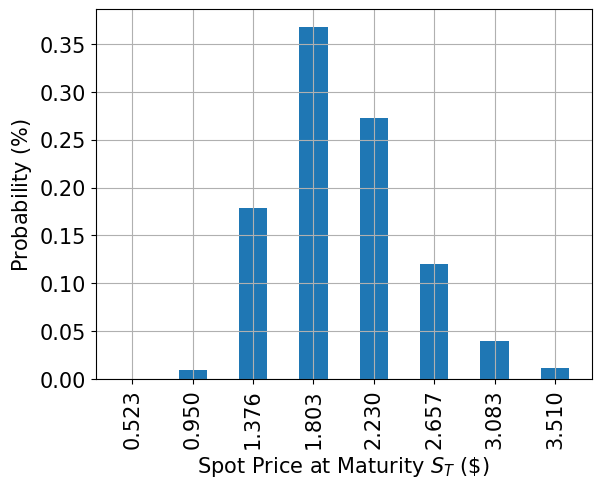

In [117]:
# 画出不确定模型的概率分布
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

## 期望收益量子电路构建
> 参考论文：[Quantum risk analysis | npj Quantum Information (nature.com)](https://www.nature.com/articles/s41534-019-0130-6)
为了使用量子电路对三角式的易操作性，我们近似了期望收益的任务。

In [118]:
# 设置期权的执行价格(应该在不确定模型的最低值和最高值之间)
strike_price = 1.896

# 设置目标函数的近似缩放
c_approx = 0.25


# 设置分段线性目标函数  
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# 通过组合不确定模型和目标函数构建QAE的A算子
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

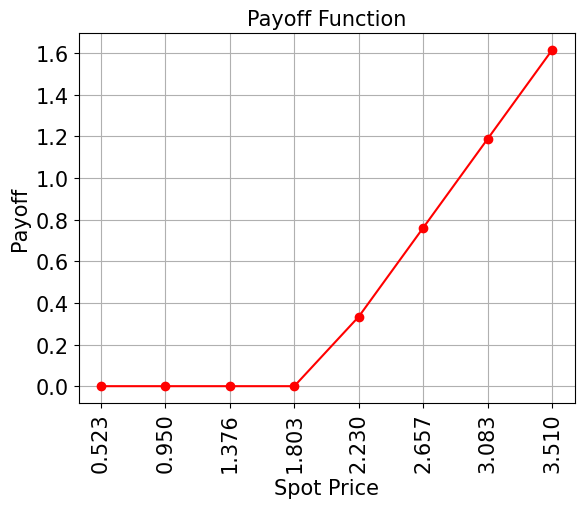

In [119]:
# 绘制期权的精确收益函数(但是这里会由于量子比特数量过少造成离散点的斜率不对齐的问题，执行价格附近最为明显)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [120]:
# 计算精确的期望值(归一化到[0,1])和Delta值
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.2481
exact delta value:   	0.4444


### 执行预估期望收益的量子计算
> 这里使用`qiskit.primitives`内的Sampler进行量子计算

In [121]:
# 通过设置epsilon和alpha来控制估计的精度和置信度
epsilon = 0.01 # 1%的精度
alpha = 0.05 # 95%的置信度
# 我们要测量的量子比特的索引应该是量子比特数(因为python的索引是从0开始的)
# index_measured = num_uncertainty_qubits 

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_call_objective.post_processing,
)
# 构建振幅估计器
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})
)

result = ae.estimate(problem)


C:\Users\16579\AppData\Local\Temp\ipykernel_13092\2393410330.py:14: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})


In [122]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.2481
Estimated value:    	0.2583
Confidence interval:	[0.2487, 0.2679]


## 测量Delta的电路构建

实现思路与期望收益的计算类似，只是不需要对算子近似，直接对辅助比特振幅测量即可。

In [123]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)
european_call_delta._objective.decompose().draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │  cmp │
state_3: ┤3     ├
         │      │
 work_0: ┤4     ├
         │      │
 work_1: ┤5     ├
         └──────┘

In [124]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

### 执行预估Delta的量子计算
> 这里使用`qiskit.primitives`内的Sampler进行量子计算

In [125]:
# 设置目标精度和置信度
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# 构建振幅估计器
ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})
)

result_delta = ae_delta.estimate(problem)

C:\Users\16579\AppData\Local\Temp\ipykernel_13092\2162794056.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=RefSampler(options={"shots": 100, "seed": 75})


In [126]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.4444
Estimated value: 	0.4453
Confidence interval: 	[0.4405, 0.4500]
